In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, GRU, Dropout
from tensorflow.keras.models import Model
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
# Load CSV file
labels_file = "../sample/sample_pair.csv"  
df = pd.read_csv(labels_file, header=None)
df.columns = ["image_path", "label"]

image_folder = "../sample/sample_image/"

# Preprocess a single image
def preprocess_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return None
    image = cv2.resize(image, target_size) / 255.0
    return np.expand_dims(image, axis=-1)

# Character mapping for labels
all_characters = set("".join(df['label']))
char_map = {char: idx for idx, char in enumerate(sorted(all_characters))}
idx_map = {idx: char for char, idx in char_map.items()}

# Encode labels
def encode_label(label):
    return [char_map[char] for char in label]

df['encoded_label'] = df['label'].apply(encode_label)
max_label_length = max(df['encoded_label'].apply(len))

# Pad labels
def pad_label(label, max_length):
    return label + [0] * (max_length - len(label))

df['padded_label'] = df['encoded_label'].apply(lambda x: pad_label(x, max_label_length))


In [ ]:
def data_generator(df, image_folder, batch_size, char_map, img_size=(128, 128)):
# Generator to yield batches of image and label data.
    num_samples = len(df)
    while True: 
        for offset in range(0, num_samples, batch_size):
            batch_data = df.iloc[offset:offset + batch_size]
            
            # Preprocess images
            batch_images = []
            batch_labels = []
            for _, row in batch_data.iterrows():
                img_path = os.path.join(image_folder, row['image_path'])
                image = preprocess_image(img_path, target_size=img_size)
                if image is not None:
                    batch_images.append(image)
                    batch_labels.append(row['encoded_label'])

            # Pad labels
            batch_images = np.array(batch_images, dtype=np.float32) 
            batch_labels = tf.ragged.constant(batch_labels).to_tensor(default_value=0)

            yield batch_images, batch_labels


In [ ]:

# Define CRNN model
def build_crnn(input_shape, num_classes):
    input_img = Input(shape=input_shape, name="image_input")
    conv1 = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation="relu", padding="same")(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    reshaped = Reshape((-1, 64))(pool2)
    rnn1 = GRU(128, return_sequences=True)(reshaped)
    rnn2 = GRU(128, return_sequences=True)(rnn1)
    dense = Dense(num_classes, activation="softmax")(rnn2)
    model = Model(inputs=input_img, outputs=dense)
    return model



In [ ]:
num_classes = len(char_map) + 1
def ctc_loss(y_true, y_pred):
    # shape (batch_size, time_steps, num_classes)
    batch_size = tf.shape(y_pred)[0]
    time_steps = tf.shape(y_pred)[1]

    # The length of each label in the batch
    label_length = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.int32), axis=1)

    # Compute the CTC loss
    loss = tf.nn.ctc_loss(
        labels=tf.cast(y_true, dtype=tf.int32), 
        logits=y_pred,
        label_length=label_length,  
        logit_length=tf.ones(shape=(batch_size,), dtype=tf.int32) * time_steps,  
        blank_index = num_classes - 1, 
        logits_time_major=False
    )
    return tf.reduce_mean(loss)


In [ ]:
# Model configuration
input_shape = (128, 128, 1)
num_classes = len(char_map) + 1 
batch_size = 32

# Build and compile model
model = build_crnn(input_shape, num_classes)

# Compile model with updated loss function
model.compile(optimizer='adam', loss=ctc_loss)

# Training parameters
batch_size = 32
train_gen = data_generator(df, image_folder, batch_size, char_map)

# Train the model
steps_per_epoch = len(df) // batch_size
history = model.fit( train_gen, steps_per_epoch=steps_per_epoch,epochs=50)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - loss: 5306.5156
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - loss: 4450.2637
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - loss: 4436.7061
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - loss: 4436.6909
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - loss: 4436.0244
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - loss: 4436.1602
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - loss: 4435.1548
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - loss: 4433.3179
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - loss: 4434.3047
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - loss: 4433.0029
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 4433.3677
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 4431.2583
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 4433.7700
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 4434.4233
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 1024, 128)      │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 1024, 128)      │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024, 218)      │        28,122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 661,520 (2.52 MB)

 Trainable params: 220,506 (861.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 441,014 (1.68 MB)

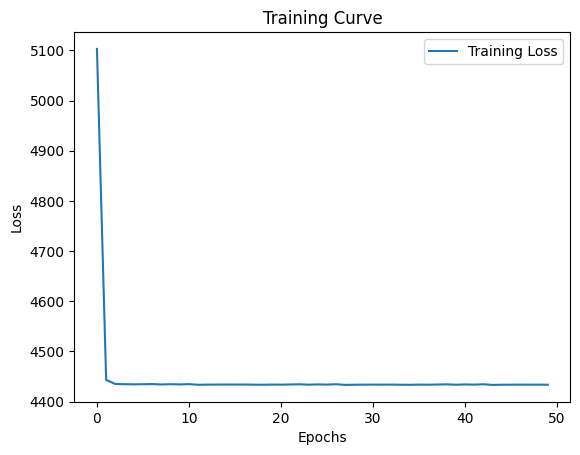

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
total_loss = sum(history.history['loss'])
print("Total Loss:", total_loss)


Total Loss: 222384.14501953125
